In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random as rnd
import scipy.io

from sklearn import preprocessing
from sklearn.svm import SVC

%matplotlib inline

## 3.3 Preparing for PCA Projections

In [2]:
# load the input data

YALE = scipy.io.loadmat('YALEBXF.mat')
X = YALE['X']
Y = YALE['Y']
nr, nc = 192, 168 # num rows & cols in images

In [3]:
# Num of Images For Each Label
maxL = 40 # 40 labels from 0...39
numims = np.zeros(maxL)
for jj in range(0,maxL):
    numims[jj] = (Y==jj).sum()

def packcw(A):
    return (A.T).reshape(-1,1)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T

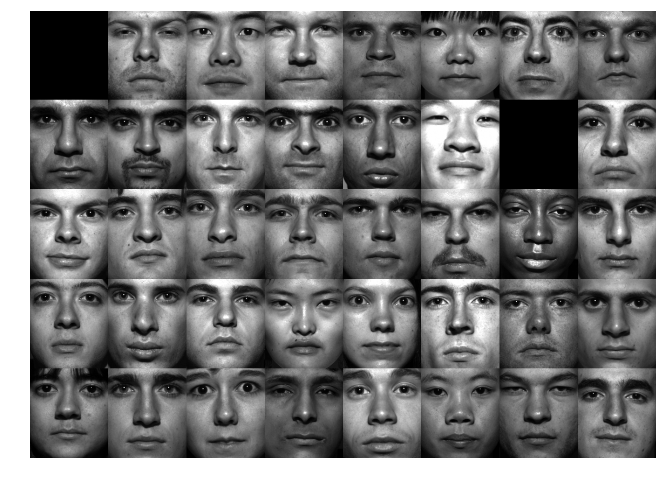

In [4]:
# Make Face Board from Data Matrix X
kk = 1
FBnr, FBnc = 5, 8
FB = np.zeros((FBnr*nr, FBnc*nc))
for jj in range(0, maxL):
    if numims[jj]>0:
        a, loc = np.where(Y == jj)
        x = X[:,loc[kk]]
        A = unpackcw(x,nr)
        row, col = divmod(jj,FBnc)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (15, 8))
plt.imshow(FB, cmap = 'gray')
plt.axis('off')
plt.show()

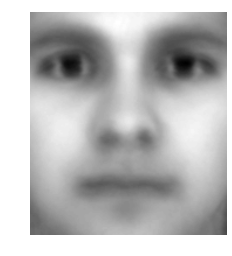

In [5]:
mu = np.sum(X, axis=1)/X.shape[1]

for i in range(X.shape[1]):
    X[:,i] -= mu

avgFaceImg = unpackcw(mu,nr)
plt.figure(1)
plt.imshow(avgFaceImg, cmap = 'gray')
plt.axis('off')
plt.show()

In [6]:
doSVD = 0

if doSVD == 1:
    U,S,V = np.linalg.svd(X, full_matrices=0, compute_uv=1)
    np.save('U.npy', U)
    np.save('S.npy', S)
    np.save('V.npy', V)
else:
    U = np.load('U.npy')
    S = np.load('S.npy')

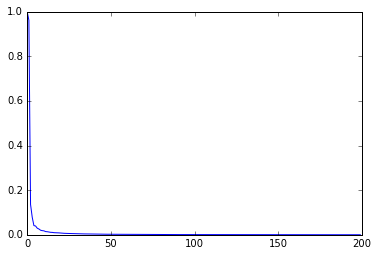

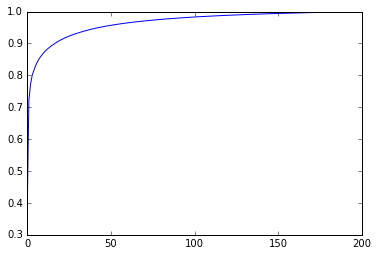

In [7]:
sigs = np.square(S[0:200]) # need to square?

plt.figure()
plt.plot(sigs /  sigs[0])
plt.show()

plt.figure()
plt.plot(np.cumsum(sigs) / sum(sigs))
plt.show()

In [8]:
mkZ = 1

if mkZ == 1:
    for d in [2,4,8,16,32,64,128,256,512]:
        Ud = U[:,0:d]
        Z = np.dot(Ud.T, X)
        name = 'Z'+str(d)
        np.save(name, Z)

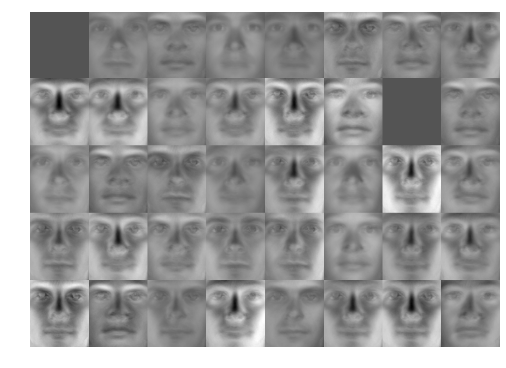

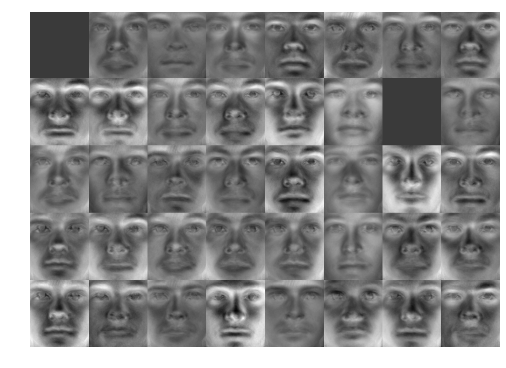

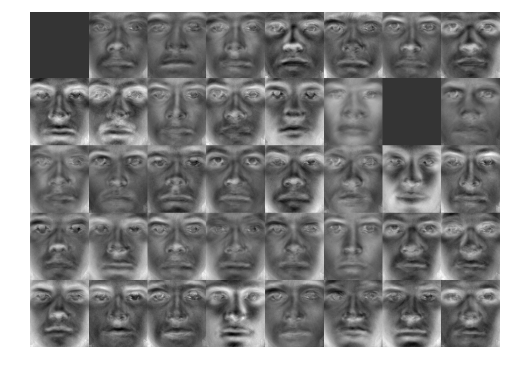

In [14]:
# Make Face Board from Approximate Images
kk = 1
FBnr, FBnc = 5, 8
for d in [8, 16, 32]:
    # load Z
    name = 'Z'+str(d)+'.npy'
    Z = np.load(name)
    Ud = U[:,0:d]

    X_approx = np.dot(Ud, Z)
    
    FB = np.zeros((FBnr*nr, FBnc*nc))
    for jj in range(0, maxL):
        if numims[jj]>0:
            a, loc = np.where(Y == jj)
            x = X_approx[:,loc[kk]]
            A = unpackcw(x,nr)
            row, col = divmod(jj,FBnc)
            rpt, cpt = row*nr, col*nc
            FB[rpt:rpt+nr, cpt:cpt+nc] = A
    plt.figure(figsize = (16, 6))
    plt.imshow(FB, cmap = 'gray')
    plt.axis('off')
    plt.show()
    

## 4.1 First Set of Experiments

In [36]:
def splitData(group1, group2, d):
    # load Z
    name = 'Z'+str(d)+'.npy'
    Z = np.load(name)

    d_train = [] #np.array((d, (len(group1) + len(group2)) * 40 ))
    d_test = [] #np.array((d, (len(group1) + len(group2)) * 40 ))

    label_train = []
    label_test = []

    for jj in group1: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(Z[:,idx])
                    label_train.append(0)
                else:
                    d_test.append(Z[:,idx])
                    label_test.append(0)        

    for jj in group2: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(Z[:,idx])
                    label_train.append(1)
                else:
                    d_test.append(Z[:,idx])
                    label_test.append(1)

    d_train = np.array(d_train)
    d_test = np.array(d_test)

    label_train = np.array(label_train)
    label_test = np.array(label_test)
    
    return d_train, d_test, label_train, label_test


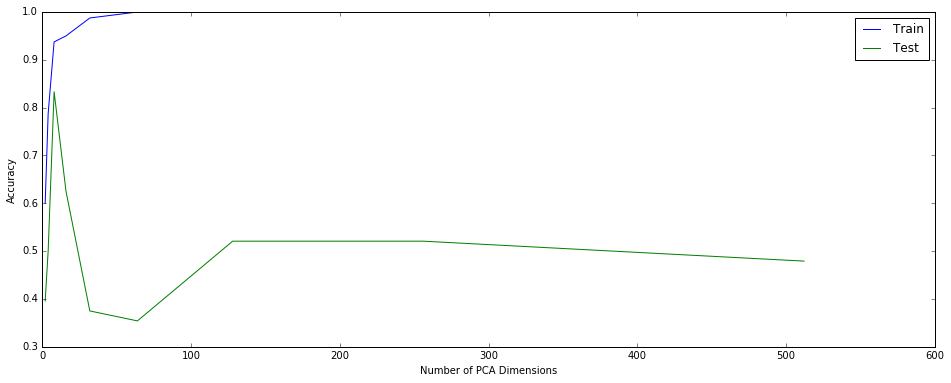

In [78]:
acc_train = []
acc_test = []
dlist = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for d in dlist:
    d_train, d_test, label_train, label_test = splitData([1],[5], d)

    scaler_train = preprocessing.StandardScaler().fit(d_train)
    d_trainst = scaler_train.transform(d_train)

    scaler_test = preprocessing.StandardScaler().fit(d_test)
    d_testst = scaler_test.transform(d_test)
        
    svc = SVC(C= 1, kernel='linear')
    svc.fit(d_trainst, label_train)
    
    acc_train.append( svc.score(d_trainst, label_train) )
    acc_test.append( svc.score(d_testst, label_test) )
    
plt.figure(figsize = (16, 6))
plt.plot(dlist, acc_train)
plt.plot(dlist, acc_test)
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Accuracy')
plt.legend(labels=['Train', 'Test'])
plt.show()

Training accuracy rapidly approaches 1 as the number of dimensions increases. However, overfitting occurs, and the testing accuracy decreases after d = 16, and slowly improves as the number of dimensions increases again. 


For subject 1 vs 5, Training accuracy becomes very high and approaches 1 as C increases. Test accuracy plummets at higher C values. At lower C values (0.1), testing accuracy is more stable across d. At very low C values (0.01), the testing accuracy becomes erratic. Similar results were seen when comparing subjects 1 and 2, and 32 and 34. 

Choosing a good C value depends on the d value chosen for PCA. We see a spike in testing accuracy around d = 16, followed by a dip and a gradual increase for a constant value of C. We use testing accuracy as a metric rather than training accuracy because it is more indicative of actual performance. 

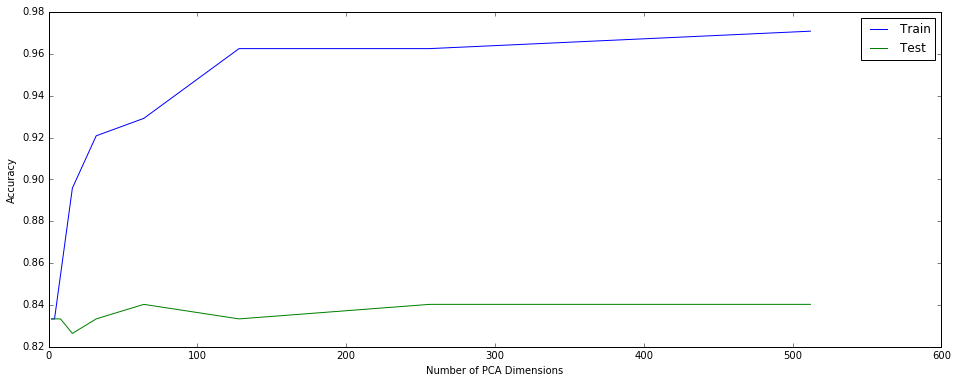

In [105]:
acc_train = []
acc_test = []
dlist = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for d in dlist:
    d_train, d_test, label_train, label_test = splitData([1],[2,3,4,5,6], d)

    scaler_train = preprocessing.StandardScaler().fit(d_train)
    d_trainst = scaler_train.transform(d_train)

    scaler_test = preprocessing.StandardScaler().fit(d_test)
    d_testst = scaler_test.transform(d_test)
        
    svc = SVC(C= 1, kernel='rbf')
    svc.fit(d_trainst, label_train)
    
    acc_train.append( svc.score(d_trainst, label_train) )
    acc_test.append( svc.score(d_testst, label_test) )
    
plt.figure(figsize = (16, 6))
plt.plot(dlist, acc_train)
plt.plot(dlist, acc_test)
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Accuracy')
plt.legend(labels=['Train', 'Test'])
plt.show()

When comparing subjects 1 and 2 through 6 using a linear kernel, we see an early spike at d = 16, followed by a dip and gradual increase back to the original spike maximum as d increases. At extremely low C values (C < 0.001) the testing acurracy is stable across all d at an accuracy of 85%. In general, past the initial dip, higher d values yield higher testing accuracy. Training accuracy decreases for low C values, possibly because overfitting is avoided. 

For the RBF kernel, the values are much more stable at higher C values over all d. This means the training accuracy is also higher. At low C values, the testing accuracy is essentially a flat line at ~85%. In general, the stabilized testing accuracy is comparable to that of the linear kernel, but the RBF kernel maintains stability at higher C values.